In [2]:
import torchvision
from torchvision import transforms
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import cv2
from diffusers import UNet2DModel
from diffusers import DDPMScheduler, DPMSolverMultistepScheduler, DDIMScheduler
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm
from diffusers.pipeline_utils import DiffusionPipeline
from diffusers import DDPMPipeline
device = "cpu"

In [90]:
batch_size = 256
preprocess = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(0.5, 0.5)
    ]
)
dataset = torchvision.datasets.FashionMNIST("./data/FashionMNIST", transform=preprocess)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [5]:
scheduler = DDPMScheduler(num_train_timesteps=1000)
# Create a model
model = UNet2DModel(
    sample_size=28,  # the target image resolution
    in_channels=1,  # the number of input channels, 3 for RGB images
    out_channels=1,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(32, 64),  # More channels -> more parameters
    down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
    ),
    up_block_types=(
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",  # a regular ResNet upsampling block
    ),
)
model = model.to(device)

In [6]:
# Training loop
optimizer = torch.optim.AdamW(model.parameters(), lr=4e-4)

losses = []

for epoch in range(5):
    for step, batch in enumerate(tqdm(dataloader)):
        clean_images = batch[0].to(device)
        # Sample noise to add to the images
        noise = torch.randn(clean_images.shape).to(clean_images.device)
        bs = clean_images.shape[0]

        # Sample a random timestep for each image
        timesteps = torch.randint(
            0, scheduler.num_train_timesteps, (bs,), device=clean_images.device
        ).long()

        # Add noise to the clean images according to the noise magnitude at each timestep
        noisy_images = scheduler.add_noise(clean_images, noise, timesteps)

        # Get the model prediction
        noise_pred = model(noisy_images, timesteps, return_dict=False)[0]

        # Calculate the loss
        loss = F.mse_loss(noise_pred, noise)
        loss.backward(loss)
        losses.append(loss.item())

        # Update the model parameters with the optimizer
        optimizer.step()
        optimizer.zero_grad()

    if (epoch + 1) % 5 == 0:
        loss_last_epoch = sum(losses[-len(dataloader) :]) / len(dataloader)
        print(f"Epoch:{epoch+1}, loss: {loss_last_epoch}")

100%|██████████| 235/235 [02:57<00:00,  1.33it/s]

Epoch:5, loss: 0.05494012896050798


In [7]:
torch.save(model, "./model/fmnist_non_condition_5epochs.pth")

In [8]:
model.conv_in.weight.shape

torch.Size([32, 1, 3, 3])

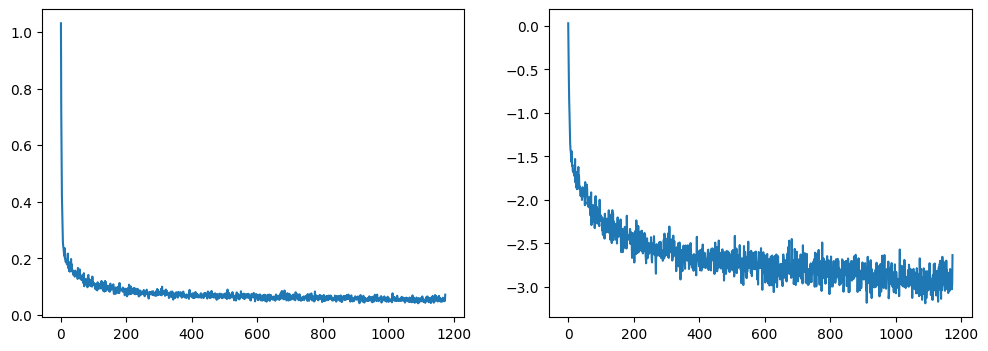

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(losses)
axs[1].plot(np.log(losses))
plt.show()

In [16]:
pipe = DDPMPipeline(unet=model, scheduler=scheduler)

In [19]:
torch.manual_seed(0)
out = pipe()
out.images[0]

100%|██████████| 1000/1000 [00:13<00:00, 73.75it/s]


In [20]:
state_dict = model.state_dict()

In [27]:
state_dict["conv_in.weight"].shape
original_weight = state_dict["conv_in.weight"]
zero_weight = torch.zeros_like(original_weight)
new_weight = torch.concat([original_weight, zero_weight], dim=1)

state_dict["conv_in.weight"] = new_weight

In [29]:
state_dict["conv_in.weight"].shape

torch.Size([32, 2, 3, 3])

In [31]:
model.conv_in.weight.shape

torch.Size([32, 1, 3, 3])

In [3]:
# Create a model
old_model = torch.load("./model/fmnist_non_condition_5epochs.pth")

state_dict = old_model.state_dict()
original_weight = state_dict["conv_in.weight"]
zero_weight = torch.zeros_like(original_weight)
new_weight = torch.concat([original_weight, zero_weight], dim=1)
state_dict["conv_in.weight"] = new_weight

new_model = UNet2DModel(
    sample_size=28,  # the target image resolution
    in_channels=2,  # the number of input channels, 3 for RGB images
    out_channels=1,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(32, 64),  # More channels -> more parameters
    down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
    ),
    up_block_types=(
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",  # a regular ResNet upsampling block
    ),
)
new_model.load_state_dict(state_dict)

<All keys matched successfully>

In [18]:
scheduler = DDPMScheduler(num_train_timesteps=1000)
pipe_new = DDPMPipeline(unet=new_model, scheduler=scheduler).to(device)
pipe_old = DDPMPipeline(unet=old_model, scheduler=scheduler).to(device)

In [19]:
print(pipe_new.unet.conv_in.weight.shape)
print(pipe_old.unet.conv_in.weight.shape)

torch.Size([32, 2, 3, 3])
torch.Size([32, 1, 3, 3])


In [71]:
torch.manual_seed(0)
sample_2c = torch.randn((1,2,28,28)).to(device)
sample_1c = sample_2c[0][0].view(1, 1, 28, 28)

out_1c = model.conv_in(sample_1c)
out_2c = new_model.conv_in(sample_2c)
torch.equal(out_1c, out_2c)

True

In [110]:
def sampling_new(pipe, init_noise, timesteps=1000):
    pipe.scheduler.set_timesteps(timesteps)

    image = init_noise.to(device)
    sketch = torch.zeros(1, 1, 28, 28).to(device)

    for t in tqdm(pipe.scheduler.timesteps):
        x = torch.concat([image, sketch], dim=1)
        with torch.no_grad():
            model_output = pipe.unet(x, t).sample
        image = pipe.scheduler.step(model_output, t, image).prev_sample

    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.cpu().permute(0, 2, 3, 1).numpy()
    image = pipe.numpy_to_pil(image)

    return image
def sampling_old(pipe, init_noise, timesteps=1000):
    pipe.scheduler.set_timesteps(timesteps)

    image = init_noise.to(device)
    for t in tqdm(pipe.scheduler.timesteps):
        with torch.no_grad():
            model_output = pipe.unet(image, t).sample

        image = pipe.scheduler.step(model_output, t, image).prev_sample

    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.cpu().permute(0, 2, 3, 1).numpy()
    image = pipe.numpy_to_pil(image)


    return image

init_noise = torch.randn(1, 1, 28, 28)
torch.manual_seed(10)
image_new = sampling_new(pipe_new, init_noise)
torch.manual_seed(10)
image_old = sampling_old(pipe_old, init_noise)


100%|██████████| 1000/1000 [00:29<00:00, 33.57it/s]


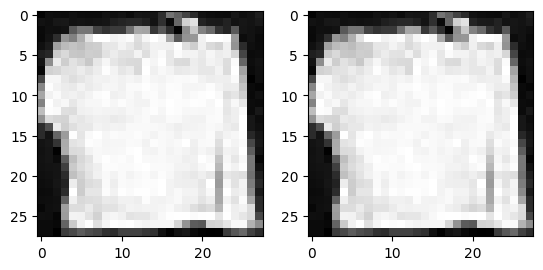

In [111]:
fig, axs = plt.subplots(1,2)
axs[0].imshow(image_new[0], 'gray')
axs[1].imshow(image_old[0], 'gray')
# image_old[0]

In [63]:
new_sd = pipe_new.unet.state_dict()
old_sd = pipe_old.unet.state_dict()
torch.equal(new_sd["down_blocks.0.downsamplers.0.conv.weight"], old_sd["down_blocks.0.downsamplers.0.conv.weight"])

True

In [112]:
pipe_new.save_pretrained("./model/init_s2i_fmnist_5epochs.pth")

In [109]:
import numpy as np
rng = np.random.RandomState(0)
a = rng.randint(0, 10)
b = rng.randint(0, 10)
print(a, b)

5 0
